import the necessary packages

In [1]:
import time
import numpy as np
import pandas as pd
import random

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions 
from selenium.webdriver.common.action_chains import ActionChains

import matplotlib.pyplot as plt
import seaborn as sns

run the appropriate codes (e.g. InStat Login, etc.)

In [210]:
%run require_scrape_xg.ipynb

the codes of the matches belonging to the rounds (unfortunately, this has to be collected manually)

In [63]:
f1 = [2306651,2306623,2306650,2306622,2306621,2306649]
f2 = [2310977,2311282,2312647,2312646,2312645]
f3 = [2314406,2314407,2314409,2314408,2314410,2314411]
f4 = [2344186,2344185,2344184,2344182,2326689]
f5 = [2346607,2347120,2347121,2346606,2326690,2346608]
f6 = [2350270,2350273,2350271,2350272,2350187,2350188]
f7 = [2351770,2351765,2351767,2351766,2351768,2351769]
f8 = [2362115,2362670,2362669,2362671,2362856,2362668]
f9 = [2387669,2387670,2387673,2387672,2387674,2387671]
f10 = [2387675,2387680,2387676,2387678,2387679,2387677]
f11 = [2387683,2387684,2387685,2387686,2387682,2387681]
f12 = [2387687,2387691,2387692,2387690,2387689,2387688]
f13 = [2387693,2387695,2387694,2387698,2387697,2387696]
f14 = [2387700,2387701,2387702,2387699,2387704,2387703]
f15 = [2387708,2387709,2387705,2387706,2387707,2387710]
f16 = [2387712,2387715,2387713,2387714,2387716,2387711]

------------------------------------------------------
### first function - due to scraping of match data

In [125]:
def make_xG_data(J=''):

    time.sleep(2.3)
    típus,timE,halF,player,xG = [],[],[],[],[]
    
    # names of team and result -------------------------------------------------------------
    t1,t2 = driver.find_element_by_xpath('//*[@id="root"]/div/section[1]/div/div/h1/span[1]/a').text,driver.find_element_by_xpath('//*[@id="root"]/div/section[1]/div/div/h1/span[3]/a').text
    result = driver.find_element_by_xpath('//*[@id="root"]/div/section[1]/div/div/h1/span[2]').text
    r1,r2 = int(result.split(':')[0]), int(result.split(':')[1])
    
    # we need the names of the teams and the result for verification purposes
    taB = f'{t1} - {t2}   {r1}:{r2}'
   

    for t  in driver.find_elements_by_class_name("tooltip"):

        típus.append(t.find_element_by_class_name('tooltip-shoot-type').text)
        tm = t.find_element_by_class_name("tooltip-time").text
        halF.append(tm.split(',')[0])
        timE.append(int(tm.split(',')[1].split(':')[0]))
        player.append(t.find_element_by_class_name("tooltip-blow-type").text)
        
        # empty spaces were found for the xg value, so we add 0.001 to it
        try :
            t.find_element_by_class_name("tooltip-shoot-xg")
            xG.append(float(t.find_element_by_class_name("tooltip-shoot-xg").text.split(':')[1]))

        except:
            xG.append(0.001)
    
    # names sequences due to dataFrame      
    ht,at = [t1 for zs in range(len(típus))],[t2 for zs in range(len(típus))]    
    
    time.sleep(0.5)
    
    # cum xG
    cumxG = np.cumsum(xG)[-1]
    # number of penalty
    pen = sum(1 for r in xG if r == 0.75)
    # nonPenalty xG
    nonPen_xG = cumxG - (pen*0.75)
    # number of shoots
    shootNum = len(xG)

    # because of the distinction between home and away teams
    if J:
        t1,ht,at = t2,at,ht
        
        # make a df  - detailed

        df = (pd.DataFrame({'name':player,'HT':ht,'AT':at,'half':halF,'time':timE,'type':típus,'xg':xG}))

        df = (df
                  .assign(time2=[df.iloc[e].time + 45  if x == 'Half 2' else df.iloc[e].time for e, x in enumerate(df.half)],
                   ))[['name','HT','AT','time2','type','xg']].sort_values('time2').reset_index(drop=True)

        # teams spreadsheet
        df2 = pd.DataFrame({'team':t1,'loc':'away','xG':cumxG,'nonPxG':nonPen_xG,'shoots':shootNum,'pen':pen,'res1':r1,'res2':r2},index=[0])
    
    else:
        
        # make a df  - detailed

        df = (pd.DataFrame({'name':player,'HT':ht,'AT':at,'half':halF,'time':timE,'type':típus,'xg':xG}))

        df = (df
                  .assign(time2=[df.iloc[e].time + 45  if x == 'Half 2' else df.iloc[e].time for e, x in enumerate(df.half)],
                   ))[['name','HT','AT','time2','type','xg']].sort_values('time2').reset_index(drop=True)
        
        df2 = pd.DataFrame({'team':t1,'loc':'home','xG':cumxG,'nonPxG':nonPen_xG,'shoots':shootNum,'pen':pen,'res1':r1,'res2':r2},index=[0])
        

    # error caution

    if round(np.cumsum(xG)[-1],1) != round(np.sum(df.xg),1):
        print(f'HIBA-----HIBA----HIBA\ncumsum: {cumxG}, sum_xG: {np.sum(df.xg)}')

    return df,df2,xG,taB

### CHECK

In [211]:
driver.get(f'https://football.instatscout.com/matches/2314408/shots')

In [213]:
check1 = make_xG_data()

In [214]:
check1[0]

,name,HT,AT,time2,type,xg
0,Dominik Kovacic,Kisvarda,Puskas,5,Shot on target,0.61
1,Bence Otvos,Kisvarda,Puskas,6,Shot on target,0.16
2,Jaroslav Navratil,Kisvarda,Puskas,15,Wide shot,0.17
3,Bence Otvos,Kisvarda,Puskas,23,Blocked shot,0.03
4,Matheus,Kisvarda,Puskas,29,Shot on target,0.18
5,Jasir Asani,Kisvarda,Puskas,29,Blocked shot,0.09
6,Jasir Asani,Kisvarda,Puskas,30,Wide shot,0.03
7,Rafal Makowski,Kisvarda,Puskas,50,Wide shot,0.05
8,Y. Karabelyov,Kisvarda,Puskas,51,Blocked shot,0.05
9,Jasir Asani,Kisvarda,Puskas,52,Shot on target,0.09


In [215]:
check1[1]

,team,loc,xG,nonPxG,shoots,pen,res1,res2
0,Kisvarda,home,2.04,2.04,18,0,1,1


In [216]:
check1[2]

[0.02,
 0.1,
 0.05,
 0.61,
 0.18,
 0.02,
 0.17,
 0.09,
 0.03,
 0.09,
 0.02,
 0.03,
 0.05,
 0.05,
 0.02,
 0.16,
 0.03,
 0.32]

GREAT!

------------------------
### Subfunction 1. - the data of the two teams are on different pages, so we are writing one

In [11]:
def switch_click():
    div_element = WebDriverWait(driver, 60).until(expected_conditions.presence_of_element_located((By.XPATH, '//*[@id="root"]/div/section[2]/article/div/div/div[1]')))
    hover = ActionChains(driver).move_to_element(div_element)
    hover.perform()

    button = WebDriverWait(driver, 30).until(expected_conditions.presence_of_element_located((By.XPATH, '//*[@id="root"]/div/section[2]/article/div/div/div[1]/div[1]/ul/li[2]')))
    hover = ActionChains(driver).move_to_element(button)
    hover.perform()

    button.click()

#### Subfunction 2. and 3. - we want to calculate an **xG point** from the xg values of the teams (*10000), so we write this function

In [7]:
def calculateWinner(home, away):
    HomeGoals = 0
    AwayGoals = 0
    
    def testShots(shots):
        Goals = 0
        
        for shot in shots:
            if random.random() <= shot:
                Goals += 1
        return Goals
    
    HomeGoals = testShots(home)
    AwayGoals = testShots(away)
    
    
    if HomeGoals > AwayGoals:
        return("home")
    elif AwayGoals > HomeGoals:
        return("away")
    else:
        return("draw")


def calculateChance(team1, team2):
    
    home = 0;
    away = 0;
    draw = 0;
    
    for i in range(0,10000):
        matchWinner = calculateWinner(team1,team2)
        if matchWinner == "home":
            home +=1
        elif matchWinner == "away":
            away +=1
        else:
            draw +=1
    
    home = home/100
    away = away/100
    draw = draw/100
    
    egy = (3*home + 1*draw)/100
    kettő = (3*away + 1*draw)/100
    
    
    return round(egy,2), round(kettő,2)

### second function - the result of which is a detailed (match, player level) and a summarized (team level) dataframe

In [207]:
def matchData(number):
    
    # number of match to driver
    driver.get(f'https://football.instatscout.com/matches/{number}/shots')
    time.sleep(2)
    
    # Collect data from team1
    team_1 = make_xG_data()
    team_1_detailed, team_1_summarize, val_1 = team_1[0],team_1[1],team_1[2]
    
    time.sleep(1)
    
    # we need a click on webpage
    switch_click()
    
    # Collect data from team2
    
    team_2 = make_xG_data('J')
    team_2_detailed, team_2_summarize,val_2 = team_2[0],team_2[1],team_2[2]
    
    time.sleep(1)
    
    df_detailed = pd.concat([team_1_detailed,team_2_detailed]).sort_values('time2').reset_index(drop=True)
    df_sum = pd.concat([team_1_summarize,team_2_summarize]).reset_index(drop=True)
    
    # calculate xg_Point
    sas = calculateChance(val_1,val_2)
    
    df_sum['xg_P'] = [p for p in sas]
    
    
    # define first goal
    
    
    if 'Goal' not in [x for x in df_detailed.type]:
        
        df_sum['first_goal'] = 'nincs Gól'
    
    else:
        
        first_Goal = [e for e, x in enumerate(df_detailed.type) if x == 'Goal']
        
        df_sum['first_goal'] = df_detailed.iloc[first_Goal[0]].HT
    
    # for verification purposes
    print(team_1[-1])
    
    return df_detailed,df_sum

### CHECK

In [217]:
check2 = matchData(2314408)

Kisvarda - Puskas   1:1


In [218]:
check2[0]

,name,HT,AT,time2,type,xg
0,Dominik Kovacic,Kisvarda,Puskas,5,Shot on target,0.61
1,Bence Otvos,Kisvarda,Puskas,6,Shot on target,0.16
2,Shahab Zahedi Tabar,Puskas,Kisvarda,9,Wide shot,0.14
3,Yoell Van Nieff,Puskas,Kisvarda,12,Goal,0.02
4,Jaroslav Navratil,Kisvarda,Puskas,15,Wide shot,0.17
5,Bence Otvos,Kisvarda,Puskas,23,Blocked shot,0.03
6,Matheus,Kisvarda,Puskas,29,Shot on target,0.18
7,Jasir Asani,Kisvarda,Puskas,29,Blocked shot,0.09
8,Jasir Asani,Kisvarda,Puskas,30,Wide shot,0.03
9,Shahab Zahedi Tabar,Puskas,Kisvarda,39,Shot on target,0.14


In [219]:
check2[1]

,team,loc,xG,nonPxG,shoots,pen,res1,res2,xg_P,first_goal
0,Kisvarda,home,2.04,2.04,18,0,1,1,2.25,Puskas
1,Puskas,away,0.87,0.87,8,0,1,1,0.55,Puskas


GREAT!

-------------------------------
third function - it takes a full round of combing

In [208]:
def forduló(*args):
    
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    
    for num in args:
        
        
        data = matchData(num)
        
        d1,d2 = data[0],data[1]
        
        df = pd.concat([df,d1])
        df2 = pd.concat([df2,d2])
        
        # for verification purposes
        print(f'match id: {num}')
        
    return df.reset_index(drop=True),df2.reset_index(drop=True)

### CHECK

In [220]:
check3 = forduló(*f1)

Paksi FC - Fehervar   2:0
match id: 2306651
Ferencvaros - Puskas   1:0
match id: 2306623
Honved - Zalaegerszegi TE   0:1
match id: 2306650
Kisvarda - Debrecen   2:2
match id: 2306622
Kecskemeti TE - Vasas   0:0
match id: 2306621
Ujpest - Mezokovesd-Zsory   1:1
match id: 2306649


In [225]:
check3[0]

,name,HT,AT,time2,type,xg
0,Zsolt Haraszti,Paksi FC,Fehervar,0,Blocked shot,0.17
1,Kenan Kodro,Fehervar,Paksi FC,3,Wide shot,0.04
2,Kenan Kodro,Fehervar,Paksi FC,11,Wide shot,0.04
3,Balazs Balogh,Paksi FC,Fehervar,16,Wide shot,0.03
4,Zsolt Haraszti,Paksi FC,Fehervar,17,Shot on target,0.02
...,...,...,...,...,...,...
149,Stefan Drazic,Mezokovesd-Zsory,Ujpest,75,Wide shot,0.08
150,Matyas Katona,Ujpest,Mezokovesd-Zsory,82,Wide shot,0.02
151,Nemanja Antonov,Ujpest,Mezokovesd-Zsory,85,Shot on target,0.01
152,Mory Kone,Ujpest,Mezokovesd-Zsory,90,Shot on target,0.20


In [226]:
check3[1]

,team,loc,xG,nonPxG,shoots,pen,res1,res2,xg_P,first_goal
0,Paksi FC,home,1.560,1.560,10,0,2,0,0.94,Paksi FC
1,Fehervar,away,2.240,2.240,20,0,2,0,1.84,Paksi FC
2,Ferencvaros,home,0.780,0.780,7,0,1,0,0.54,Ferencvaros
3,Puskas,away,1.870,1.120,16,1,1,0,2.24,Ferencvaros
4,Honved,home,1.112,1.112,10,0,0,1,1.03,Zalaegerszegi TE
5,Zalaegerszegi TE,away,1.530,1.530,16,0,0,1,1.69,Zalaegerszegi TE
6,Kisvarda,home,2.580,1.830,17,1,2,2,1.90,Kisvarda
7,Debrecen,away,1.850,1.850,12,0,2,2,0.88,Kisvarda
8,Kecskemeti TE,home,0.470,0.470,9,0,0,0,0.53,nincs Gól
9,Vasas,away,1.540,1.540,15,0,0,0,2.23,nincs Gól


GREAT!

--------------------------
fourth function - we line up the teams of the given match with the necessary values (diff. home and away)

In [50]:
def arrange_round(dataFrame, fordulóSzám):
    
    # define the columns
    col = ['team','loc','xG','nPxG','shoot','pen','goal','goal_aga','xGP','firstGoal','oppTeam','opp_loc','opp_xG','opp_nPxG','opp_shoot','opp_pen','goal_aga2','goal2','opp_xGp']
    vv,ww = pd.DataFrame(),pd.DataFrame()
    
    # because we need them in pairs
    for tix in range(0,len(dataFrame),2):
        
        # for the home teams 
        csk = pd.DataFrame({k:v for k,v in zip(col,list(dataFrame.iloc[tix].values)+list(dataFrame.iloc[tix+1].values[:-1]))}, index = [0])
        vv = pd.concat([vv,csk])
        
        # for the second team
        csk2 = pd.DataFrame({k:v for k,v in zip(col,list(dataFrame.iloc[tix+1].values)+list(dataFrame.iloc[tix].values[:-1]))}, index = [0])
        ww = pd.concat([ww,csk2])
        
    # concat dataframes
    ww = ww.rename(columns={'goal2':'goal','goal_aga':'goal_aga2','goal_aga2':'goal_aga','goal':'goal2'})
    df = pd.concat([vv,ww])
    df['week'] = fordulóSzám
    df = df[['week','team','oppTeam','loc','firstGoal','xG','nPxG','shoot','pen','xGP','goal','goal_aga','opp_xG','opp_nPxG','opp_shoot','opp_pen','opp_xGp']].reset_index(drop=True)

    return df,ww

### CHECK

In [222]:
check4 = arrange_round(check3[1],1)

In [224]:
check4[0]

,week,team,oppTeam,loc,firstGoal,xG,nPxG,shoot,pen,xGP,goal,goal_aga,opp_xG,opp_nPxG,opp_shoot,opp_pen,opp_xGp
0,1,Paksi FC,Fehervar,home,Paksi FC,1.560,1.560,10,0,0.94,2,0,2.240,2.240,20,0,1.84
1,1,Ferencvaros,Puskas,home,Ferencvaros,0.780,0.780,7,0,0.54,1,0,1.870,1.120,16,1,2.24
2,1,Honved,Zalaegerszegi TE,home,Zalaegerszegi TE,1.112,1.112,10,0,1.03,0,1,1.530,1.530,16,0,1.69
3,1,Kisvarda,Debrecen,home,Kisvarda,2.580,1.830,17,1,1.90,2,2,1.850,1.850,12,0,0.88
4,1,Kecskemeti TE,Vasas,home,nincs Gól,0.470,0.470,9,0,0.53,0,0,1.540,1.540,15,0,2.23
5,1,Ujpest,Mezokovesd-Zsory,home,Ujpest,2.010,2.010,16,0,2.34,1,1,0.680,0.680,6,0,0.47
6,1,Fehervar,Paksi FC,away,Paksi FC,2.240,2.240,20,0,1.84,0,2,1.560,1.560,10,0,0.94
7,1,Puskas,Ferencvaros,away,Ferencvaros,1.870,1.120,16,1,2.24,0,1,0.780,0.780,7,0,0.54
8,1,Zalaegerszegi TE,Honved,away,Zalaegerszegi TE,1.530,1.530,16,0,1.69,1,0,1.112,1.112,10,0,1.03
9,1,Debrecen,Kisvarda,away,Kisvarda,1.850,1.850,12,0,0.88,2,2,2.580,1.830,17,1,1.90


In [227]:
check4[1]

,team,loc,xG,nPxG,shoot,pen,goal2,goal_aga2,xGP,firstGoal,oppTeam,opp_loc,opp_xG,opp_nPxG,opp_shoot,opp_pen,goal_aga,goal,opp_xGp
0,Fehervar,away,2.24,2.24,20,0,2,0,1.84,Paksi FC,Paksi FC,home,1.560,1.560,10,0,2,0,0.94
0,Puskas,away,1.87,1.12,16,1,1,0,2.24,Ferencvaros,Ferencvaros,home,0.780,0.780,7,0,1,0,0.54
0,Zalaegerszegi TE,away,1.53,1.53,16,0,0,1,1.69,Zalaegerszegi TE,Honved,home,1.112,1.112,10,0,0,1,1.03
0,Debrecen,away,1.85,1.85,12,0,2,2,0.88,Kisvarda,Kisvarda,home,2.580,1.830,17,1,2,2,1.90
0,Vasas,away,1.54,1.54,15,0,0,0,2.23,nincs Gól,Kecskemeti TE,home,0.470,0.470,9,0,0,0,0.53
0,Mezokovesd-Zsory,away,0.68,0.68,6,0,1,1,0.47,Ujpest,Ujpest,home,2.010,2.010,16,0,1,1,2.34


GREAT!

--------------------------
fifth function - let's add the functions together

In [228]:
def fullFunc(fordulóSzám,*args):
    
    df = forduló(*args)
    
    
    df_summarize = arrange_round(df[1],fordulóSzám)
    
    df[0]['fixGól'] = np.where(df[0].type == 'Goal',1,0)
    
    # for verification purposes
    print(f'--------- DONE {fordulóSzám}.forduló ---------------' )
    
    return df_summarize, df[0]

---------------------
Last round! - all matches of all rounds are collected

In [185]:
start = time.time()
gh1 = pd.DataFrame()
gh2 = pd.DataFrame()
tz = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16]

for ra in range(1,17):
    jj = fullFunc(ra,*tz[ra-1])
    
    gh1 = pd.concat([gh1,jj[0][0]]).reset_index(drop=True)
    gh2 = pd.concat([gh2,jj[1]]).reset_index(drop=True)

end = time.time()
print(f'It took {round((end - start)/60),2} minutes')

Paksi FC - Fehervar   2:0
match id: 2306651
Ferencvaros - Puskas   1:0
match id: 2306623
Honved - Zalaegerszegi TE   0:1
match id: 2306650
Kisvarda - Debrecen   2:2
match id: 2306622
Kecskemeti TE - Vasas   0:0
match id: 2306621
Ujpest - Mezokovesd-Zsory   1:1
match id: 2306649
--------- DONE 1.forduló ---------------
Vasas - Paksi FC   2:2
match id: 2310977
Debrecen - Kecskemeti TE   1:1
match id: 2311282
Kisvarda - Mezokovesd-Zsory   4:2
match id: 2312647
Puskas - Ujpest   2:0
match id: 2312646
Fehervar - Honved   4:0
match id: 2312645
--------- DONE 2.forduló ---------------
Debrecen - Vasas   1:1
match id: 2314406
Kecskemeti TE - Mezokovesd-Zsory   1:0
match id: 2314407
HIBA-----HIBA----HIBA
cumsum: 2.95, sum_xG: 2.9499999999999993
Ujpest - Zalaegerszegi TE   1:1
match id: 2314409
Kisvarda - Puskas   1:1
match id: 2314408
Ferencvaros - Fehervar   4:0
match id: 2314410
Honved - Paksi FC   3:3
match id: 2314411
--------- DONE 3.forduló ---------------
Vasas - Honved   1:2
match id: 2

GREAT!

we are done collecting and organizing the data

----------------
### let's analyze

make a table according to xG Points

In [4]:
df_xGtab = gh1.groupby('team').sum().sort_values('xGP',ascending=False).reset_index().drop('week',axis=1)

In [5]:
df_xGtab

,team,xG,nPxG,shoot,pen,xGP,goal,goal_aga,opp_xG,opp_nPxG,opp_shoot,opp_pen,opp_xGp
0,Puskas,26.891,25.391,227,2,26.96,22,18,19.960,18.460,181,2,17.32
1,Ujpest,25.791,24.291,264,2,26.96,19,33,18.680,17.180,129,2,17.36
2,Ferencvaros,31.870,28.870,227,4,26.40,34,12,21.252,17.502,187,5,12.86
3,Kisvarda,26.982,23.982,220,4,23.81,31,29,23.803,20.053,179,5,20.37
4,Debrecen,28.611,27.861,214,1,22.98,27,27,27.790,24.790,217,4,21.36
5,Vasas,19.851,19.101,164,1,21.93,13,20,19.441,19.441,227,0,21.89
6,Mezokovesd-Zsory,21.071,18.071,175,4,19.62,18,26,25.791,24.291,212,2,24.73
7,Honved,22.573,18.823,170,5,19.29,16,27,27.161,26.411,226,1,24.77
8,Paksi FC,22.241,20.741,165,2,18.79,27,26,24.190,20.440,179,5,22.46
9,Kecskemeti TE,21.511,16.261,168,7,18.08,23,16,27.782,26.282,272,2,26.46


there should only be one match in the list - choose the one marked home

In [6]:
home = gh1[gh1['loc'] == 'home']

In [7]:
home.sample()

,week,team,oppTeam,loc,firstGoal,xG,nPxG,shoot,pen,xGP,goal,goal_aga,opp_xG,opp_nPxG,opp_shoot,opp_pen,opp_xGp
145,13,Ferencvaros,Zalaegerszegi TE,home,Ferencvaros,2.87,2.87,15,0,1.78,2,1,2.25,2.25,18,0,1.01


we subtract the goals conceded from the scored goals and the total xG of the opponent is subtracted from the total xG of the home team

In [10]:
df_P = (home
    .assign(
        gDiff = home.goal-home.goal_aga,
           xgDiff = home.xG-home.opp_xG))

In [11]:
df_P.sample()

,week,team,oppTeam,loc,firstGoal,xG,nPxG,shoot,pen,xGP,goal,goal_aga,opp_xG,opp_nPxG,opp_shoot,opp_pen,opp_xGp,gDiff,xgDiff
128,12,Vasas,Kecskemeti TE,home,Kecskemeti TE,0.49,0.49,11,0,0.68,1,2,1.29,1.29,15,0,2.02,-1,-0.8


short check

---------------------------------------------
how many matches are we looking at?

In [13]:
len(df_P) # 94 matches (16.rounds but Ferencváros 14 and two teams played 15 matches. =>94 matches (two missing games))

94

Case 1.

the home team wins, but the away team has a higher xG

In [14]:
len(df_P[(df_P.gDiff>0) & (df_P.xgDiff<0)])  #14 matches

14

Case 2.

the away team wins, but the home team has a higher xG

In [15]:
len(df_P[(df_P.gDiff<0) & (df_P.xgDiff>0)]) #8 matches

8

Collect the cases we are interested in from the dataframe

In [19]:
df_cases = pd.concat([df_P[(df_P.gDiff<0) & (df_P.xgDiff>0)],df_P[(df_P.gDiff>0) & (df_P.xgDiff<0)]]).reset_index(drop=True)

In [21]:
# check
len(df_cases)

22

In [25]:
22/94

0.23404255319148937

24% of the matches fall into this 'unexpected wins' category

In [22]:
df_cases

,week,team,oppTeam,loc,firstGoal,xG,nPxG,shoot,pen,xGP,goal,goal_aga,opp_xG,opp_nPxG,opp_shoot,opp_pen,opp_xGp,gDiff,xgDiff
0,5,Ujpest,Paksi FC,home,Paksi FC,1.920,1.920,16,0,1.35,2,3,1.900,1.150,7,1,1.38,-1,0.020
1,6,Paksi FC,Kisvarda,home,Kisvarda,0.970,0.970,7,0,1.44,1,3,0.870,0.870,8,0,1.23,-2,0.100
2,7,Kisvarda,Honved,home,Honved,1.270,1.270,16,0,1.34,0,1,1.211,0.461,6,1,1.35,-1,0.059
3,9,Mezokovesd-Zsory,Paksi FC,home,Mezokovesd-Zsory,1.510,1.510,12,0,1.74,1,2,1.040,1.040,13,0,0.98,-1,0.470
4,10,Ujpest,Kecskemeti TE,home,Kecskemeti TE,2.510,1.760,25,1,2.79,1,2,0.290,0.290,5,0,0.13,-1,2.220
5,12,Debrecen,Kisvarda,home,Debrecen,1.291,1.291,11,0,1.44,2,3,1.200,1.200,12,0,1.27,-1,0.091
6,13,Honved,Fehervar,home,Fehervar,2.050,2.050,11,0,1.70,0,1,1.610,1.610,9,0,1.04,-1,0.440
7,13,Paksi FC,Vasas,home,Vasas,1.930,1.930,18,0,1.71,0,1,1.430,1.430,8,0,1.01,-1,0.500
8,1,Paksi FC,Fehervar,home,Paksi FC,1.560,1.560,10,0,0.94,2,0,2.240,2.240,20,0,1.84,2,-0.680
9,1,Ferencvaros,Puskas,home,Ferencvaros,0.780,0.780,7,0,0.56,1,0,1.870,1.120,16,1,2.23,1,-1.090


Let's examine the cases visually

What we are interested in is the upper left and lower right part of the plot. Here are the 22 cases we found previously

But before that, let's collect (from the 22 matches) the matches where the winning team scored the first goal and thus the xG of the losing team was higher
(these are marked with a red cross on the plot)

In [29]:
e = (df_cases.firstGoal==df_cases.team) & (df_cases.xgDiff>0)
k = (df_cases.firstGoal==df_cases.team) & (df_cases.xgDiff<0)
df_first_cases = df_cases[e | k].reset_index(drop=True)

In [31]:
len(df_first_cases)

16

In [32]:
16/22

0.7272727272727273

In 16 out of 22 matches (72%), the first goal was scored by the winning team, but with less xG

In [30]:
df_first_cases

,week,team,oppTeam,loc,firstGoal,xG,nPxG,shoot,pen,xGP,goal,goal_aga,opp_xG,opp_nPxG,opp_shoot,opp_pen,opp_xGp,gDiff,xgDiff
0,9,Mezokovesd-Zsory,Paksi FC,home,Mezokovesd-Zsory,1.510,1.510,12,0,1.74,1,2,1.040,1.040,13,0,0.98,-1,0.470
1,12,Debrecen,Kisvarda,home,Debrecen,1.291,1.291,11,0,1.44,2,3,1.200,1.200,12,0,1.27,-1,0.091
2,1,Paksi FC,Fehervar,home,Paksi FC,1.560,1.560,10,0,0.94,2,0,2.240,2.240,20,0,1.84,2,-0.680
3,1,Ferencvaros,Puskas,home,Ferencvaros,0.780,0.780,7,0,0.56,1,0,1.870,1.120,16,1,2.23,1,-1.090
4,3,Kecskemeti TE,Mezokovesd-Zsory,home,Kecskemeti TE,1.070,1.070,12,0,0.50,1,0,2.460,1.710,21,1,2.32,1,-1.390
5,6,Puskas,Mezokovesd-Zsory,home,Puskas,0.670,0.670,8,0,0.78,1,0,1.340,1.340,13,0,1.94,1,-0.670
6,7,Kecskemeti TE,Paksi FC,home,Kecskemeti TE,2.130,1.380,13,1,1.33,3,1,2.210,2.210,21,0,1.44,2,-0.080
7,8,Paksi FC,Debrecen,home,Paksi FC,1.360,1.360,8,0,0.92,1,0,1.980,1.980,11,0,1.83,1,-0.620
8,8,Fehervar,Mezokovesd-Zsory,home,Fehervar,0.410,0.410,5,0,0.68,2,1,1.180,1.180,12,0,2.02,1,-0.770
9,9,Kecskemeti TE,Ferencvaros,home,Kecskemeti TE,1.360,0.610,8,1,1.30,2,0,1.490,1.490,22,0,1.41,2,-0.130


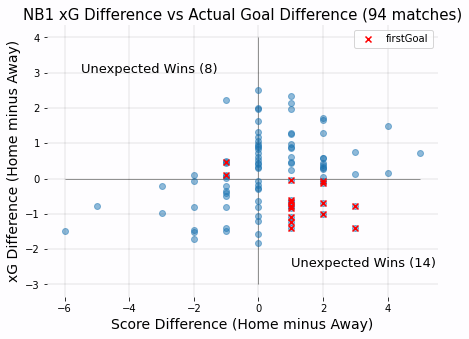

In [24]:
fig = plt.figure(figsize=(7, 5))
ax = plt.subplot(111, )

backboard =  '#fefdff'

ax.grid(ls='-',lw=0.1,color='k',zorder=1, which='both')

orient = ['top','bottom','left','right']
for m in orient:
        ax.spines[m].set_visible(False)

fig.set_facecolor(backboard)
ax.patch.set_facecolor(backboard)
ax.scatter(df_P.gDiff,df_P.xgDiff,alpha=0.5)
plt.hlines(0,-6,5, color = 'gray',lw=0.8,zorder=0)
plt.vlines(0,-3,4,color='gray',lw=0.8,zorder=0)

dfÚj = df_kérdéses[e | k]
plt.scatter(dfÚj.gDiff,dfÚj.xgDiff,color='r',marker='x', label='firstGoal')


plt.text(-5.5, 3, 'Unexpected Wins (8)',color='k', fontsize=13)
plt.text(1, -2.5, 'Unexpected Wins (14)',color='k', fontsize=13)

ax.set_xlabel('Score Difference (Home minus Away)',  size=14)
ax.set_ylabel('xG Difference (Home minus Away)',  size=14)
plt.legend()
plt.title('NB1 xG Difference vs Actual Goal Difference (94 matches)', size=15);